In [1]:
! pip install -r requirements.txt

## Connect to Azure Workspace
1. Connect to Azure Machine Learning Workspace. The Azure Machine Learning Workspace is the top-level resource for the service. It provides a centralized place to work (a curated environment) with all the artifacts

In [2]:
# Handle to the workspace
from azure.ai.ml import MLClient

# Authentication package
from azure.keyvault.secrets import SecretClient
from azure.identity import DefaultAzureCredential, CredentialUnavailableError
import os
import dotenv
dotenv.load_dotenv()
SUBSCRIPTION_ID = os.getenv("SUBSCRIPTION_ID")
RESOURCE_GROUP_NAME = os.getenv("RESOURCE_GROUP_NAME")
WORKSPACE_NAME = os.getenv("WORKSPACE_NAME")
VAULT_URL = os.getenv("AZURE_VAULT_URL")
credential = DefaultAzureCredential()
# secret_name = "MLKEY"
# secret_client = SecretClient(vault_url = VAULT_URL, credential = credential)
# secret = secret_client.get_secret(secret_name)


from azure.ai.ml import command, Input

from azure.ai.ml.entities import(
    ManagedOnlineEndpoint,
    ManagedOnlineDeployment,
    Model,
    CodeConfiguration
)

# Create BlobServiceClient
from azure.storage.blob import BlobServiceClient


2. Get a Handle to the workspace by providing subscription Id, Resource Group name and workspace name.

In [3]:
# Get a handle to the workspace
ml_client = MLClient(
    credential=credential,
    subscription_id=SUBSCRIPTION_ID,
    resource_group_name=RESOURCE_GROUP_NAME,
    workspace_name=WORKSPACE_NAME,
)


## Create a compute Resource
1. Azure Machine Learning needs a compute resource to run a job. This resource can be simgle or multi-node machines with Linux or Windows OS
2. For this example - we will use Standard_NC4as_T4_v3 with 4 cores, 28 GB RAM, 176 GB Storage
3. More reosurces are listed in - https://azure.microsoft.com/en-us/pricing/details/machine-learning/#pricing

In [5]:
from azure.ai.ml.entities import AmlCompute

gpu_compute_target = "gpu-cluster"

try:
    # Check if the compute target already exists
    gpu_cluster = ml_client.compute.get(gpu_compute_target)
    print(f"GPU Cluster already present: {gpu_compute_target}")
except Exception:
    print("Creating new gpu compute target..")
    # Create Azure ML compute object with the intended parameters
    gpu_cluster = AmlCompute(
        # Name Assigned to compute cluster
        name = "gpu-cluster",
        # Azure M Compute is the on-demand VM Service
        type = "amlcompute",
        # VM Family
        size = "Standard_NC4as_T4_v3",
        # Minimum running nodes when there is no job running
        min_instances= 0 ,
        # nodes in cluster
        max_instances= 4,
        # How many secods will the node be running after the job termination-in case async fn are running
        idle_time_before_scale_down = 180,
        # Dedicated or LowPriority
        tier = "LowPriority"       
    )
    # Now we pass the object to MLClient's create_or_update method
    gpu_cluster = ml_client.begin_create_or_update(gpu_cluster).result()
    print(f'AMLCompute with name {gpu_cluster.name} created, the compute size is {gpu_cluster.size}')




Creating new gpu compute target..
AMLCompute with name gpu-cluster created, the compute size is Standard_NC4as_T4_v3


## Create a job environment
1. An Azure Machine learning eenvironment encapsulates the dependencies needed to run machine elarning training script on the created compute resource. This environment is similar to python venv on local machine.
2. The Azure machine learning environemtn allows us to either use a curated environment - useful for common training and inference scenarios - or create a custom environment using a docker image or Conda configuration
3. In this scenario we will use curated Azure Machine Learning environment - "AzureML-tensorflow-2.16-ubuntu20.04-py38-cuda11-gpu"

In [6]:
curated_env_name = "AzureML-tensorflow-2.16-cuda11@latest"

## Configure and submit the training job
This section will deal entirely with training a model on standard MNIST dataset and then executing the training script on Azure Machine Learning
### Prepare the training script
In the training script, app.py, we create a simple CNN that trains on the MNIST Dataset 
1. Configuration: Sets up hyperparameters - batch size, epochs and learning rate
2. Get Current Run: Retrieves the curent Azure ML run context to log metrics and artifacts
3. Load and Preprocess Data: Loads the MNIST dataset
4. Create CNN Model
5. Train Model
6. SaveModel - to outputs directory
7. Log Metrics - each epoch to azure ml
8. Complete Run - end of azure ml run



In [8]:
%%writefile app.py

import os
import tensorflow as tf
from azureml.core import Run
from azureml.core.model import Model
from tensorflow.keras import datasets, layers, models

# 1. Configuration
batch_size = 32
epochs = 5
learning_rate = 0.001

# 2. Get Current Run
run = Run.get_context()

# 3. Load and Preprocess
(X_train, y_train), (X_test, y_test) = datasets.mnist.load_data()
X_train, X_test = X_train/255.0, X_test/255.0

X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

# 4. Create a CNN Model
class CNNModel(tf.keras.Model):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = layers.Conv2D(32, (3,3), activation = 'relu', input_shape(28,28,1))
        self.maxpool1 = layers.MaxPooling2D((2,2))
        self.conv2 = layers.Conv2D(64, (3,3), activation = 'relu')
        self.maxpool2 = layers.MaxPooling2D((2,2))
        self.conv3 = layers.Conv2D(64,(3,3), activation = 'relu')
        self.flatten = layers.Flatten()
        self.fc1 = layers.Dense(64, activation = 'relu')
        self.fc2 = layers.Dense(10)
    
    def call(self, x):
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.conv3(x)
        x = self.flatten(x)
        x = self.fc1(x)
        return self.fc2(x)
model = CNNModel()
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate),
                loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
                metrics = ['accuracy']
)

# 5. Train the Model
history = model.fit(X_train, y_train, epochs = epochs, batch_size = batch_size, validation_data = (X_test, y_test))

# 6. Save the model as Tensorflow SavedModel
os.makedirs("outputs",exist_ok=True)
tf.saved_model.save(model, "outputs/mnist_cnn_model")

# 7. Log Metrics and Artifacts
for epoch in range(epochs):
    run.log('epoch', epoch)
    run.log('loss', history.history['loss'][epoch])
    run.log('accuracy', history.history['accuracy'][epoch])   
    run.log('val_loss', history.history['val_loss'][epoch])   
    run.log('val_accuracy', history.history['val_accuracy'][epoch])  

# 8. Complete Run

run.complete()        

Writing app.py


# Configure the command (CLI)
We use the general purpose command to run the training script and perform our desired tasks.
For the parameter values:
1. provide the **compute cluster** gpu_compute_target = "gpu-cluster"
2. provide the **curated envirnment name** curated_env_name = "AzureML-tensorflow-2.16-cuda11@latest"
3. configure the command line action - in this case - python app.py
3. configure the metadata such as **display name** and **experiment** name - an experiment is a container for  all the iterations on a certain project. All the jobs submited under the same experiment would be listed next to each other im Azure ML studio.

In [15]:
from azure.ai.ml import command
from azure.ai.ml import UserIdentityConfiguration
from azure.ai.ml import Input

# Define the job configuration
job = command(
    compute = gpu_compute_target,
    environment = curated_env_name,
    code = ".", # Current working directory
    command = "python app.py",
    experiment_name = "azure_cnn_demo",
    display_name="Azure Deployment of a Tensorflow CNN Model"
)


# Submit the job
create_or_update on ml_client.jobs is used to submit the job
Once completed, the job will register a model in ML workspace (as a result of training) and output a link for viewing the job in Azure Machine Learning Studio

In [19]:
# from azure.ai.ml.entities import AzureBlobDatastore
# store = AzureBlobDatastore(
#     name="MLBLOB",
#     description="MLBLOB",
#     account_name="mlworkspace6870709472",
#     container_name="azureml"
# )

# ml_client.create_or_update(store)

AzureBlobDatastore({'type': <DatastoreType.AZURE_BLOB: 'AzureBlob'>, 'name': 'mlblob', 'description': 'MLBLOB', 'tags': {}, 'properties': {}, 'print_as_yaml': False, 'id': '/subscriptions/bbf5eb8c-3046-4876-8eb1-5210a3e6750f/resourceGroups/ML_RESOURCE_GROUP/providers/Microsoft.MachineLearningServices/workspaces/ML_WORKSPACE/datastores/mlblob', 'Resource__source_path': '', 'base_path': 'd:\\PracticeProjects\\Azure_ML_CNN_demo', 'creation_context': None, 'serialize': <msrest.serialization.Serializer object at 0x000001E1A91E0690>, 'credentials': <azure.ai.ml.entities._credentials.NoneCredentialConfiguration object at 0x000001E1A7C92350>, 'container_name': 'azureml', 'account_name': 'mlworkspace6870709472', 'endpoint': 'core.windows.net', 'protocol': 'https'})

In [23]:
ml_client.jobs.create_or_update(job)

Experiment,Name,Type,Status,Details Page
azure_cnn_demo,keen_yacht_7my12k3ygv,command,Starting,Link to Azure Machine Learning studio


# Job execution
1. Preparing: A docker image is created according to the environment defined. This image is uploaded to the workspace's container registry and cached for later runs.
2. Logs are streamed to the job history and can be viewed to monitor progress. If a curated environment is specified, the cached image backing that curated environemnt will be used.
3. Scaling: The cluster attempts to scale up if it requires more nodes to execute the run than are currently available
4. Running: All script in the script folder **src** are uploaded to the compute target, data stores are mounted or copied, and the script is executed. Outputs from **STDOUT** and the **./logs** folder are streamed to the job history and can be used to monitor the job.

# Metrics Overview
TBD

# Register the Model
Register the model thru UI itself instead of code
1. Navigate tot he training job executed in Jobs under Assets in the left panel

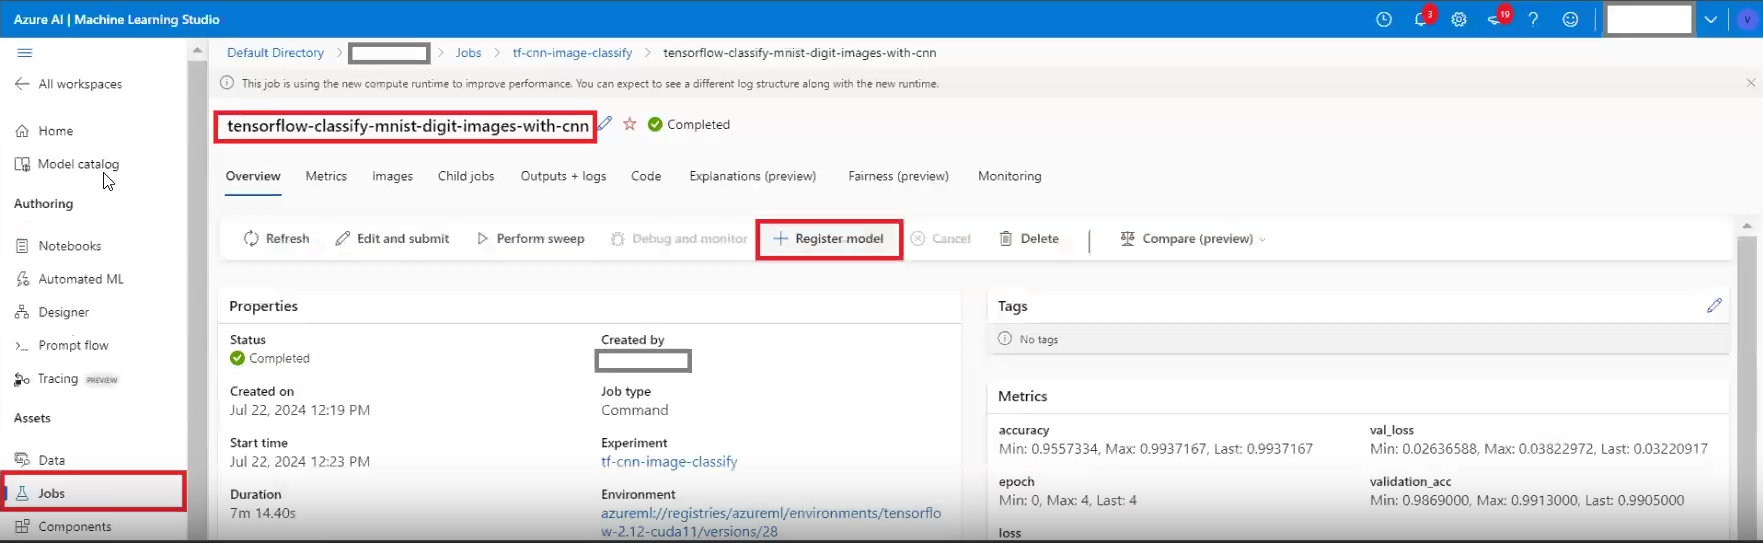

2. Select the jobs outputs corresponding to the executed training job.

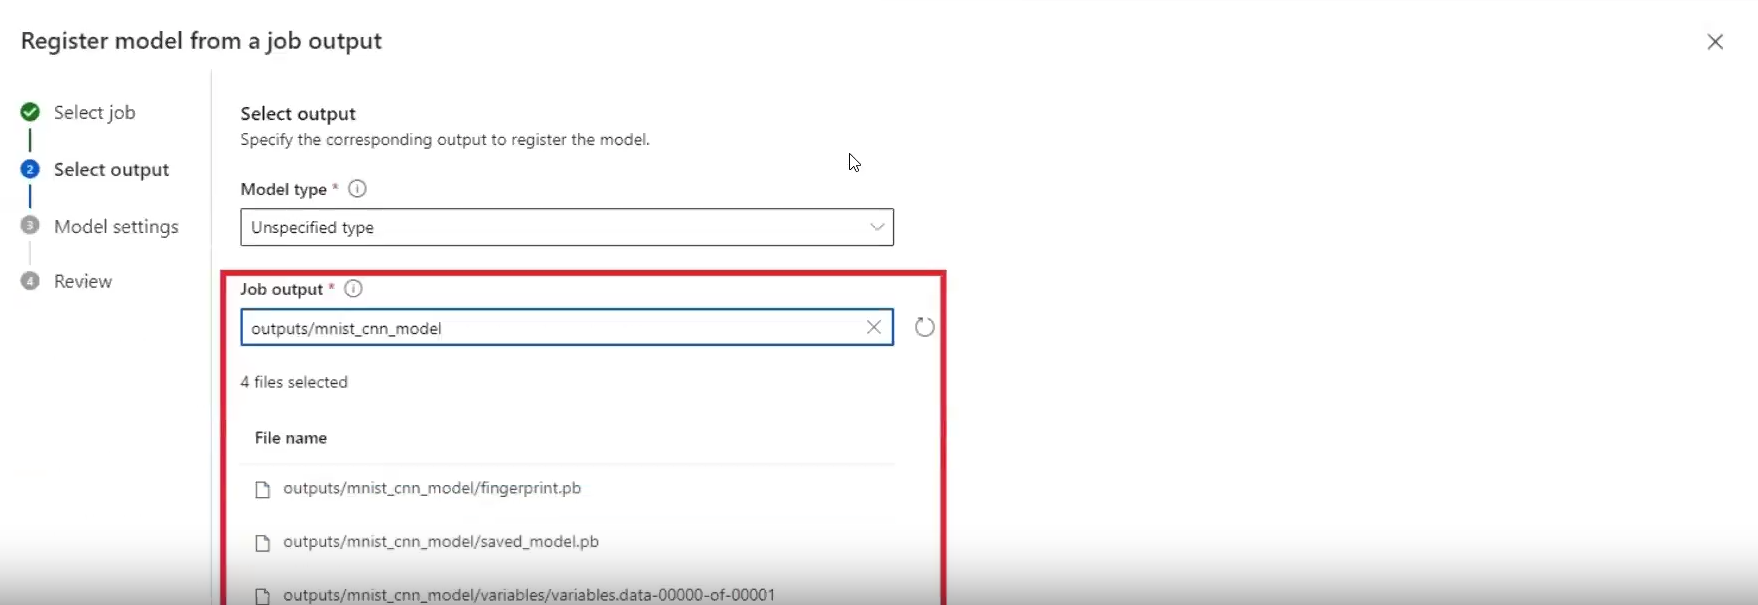


3. Enter the name and Description of the Model as per your desired choice and set it's version to 1. Next >>

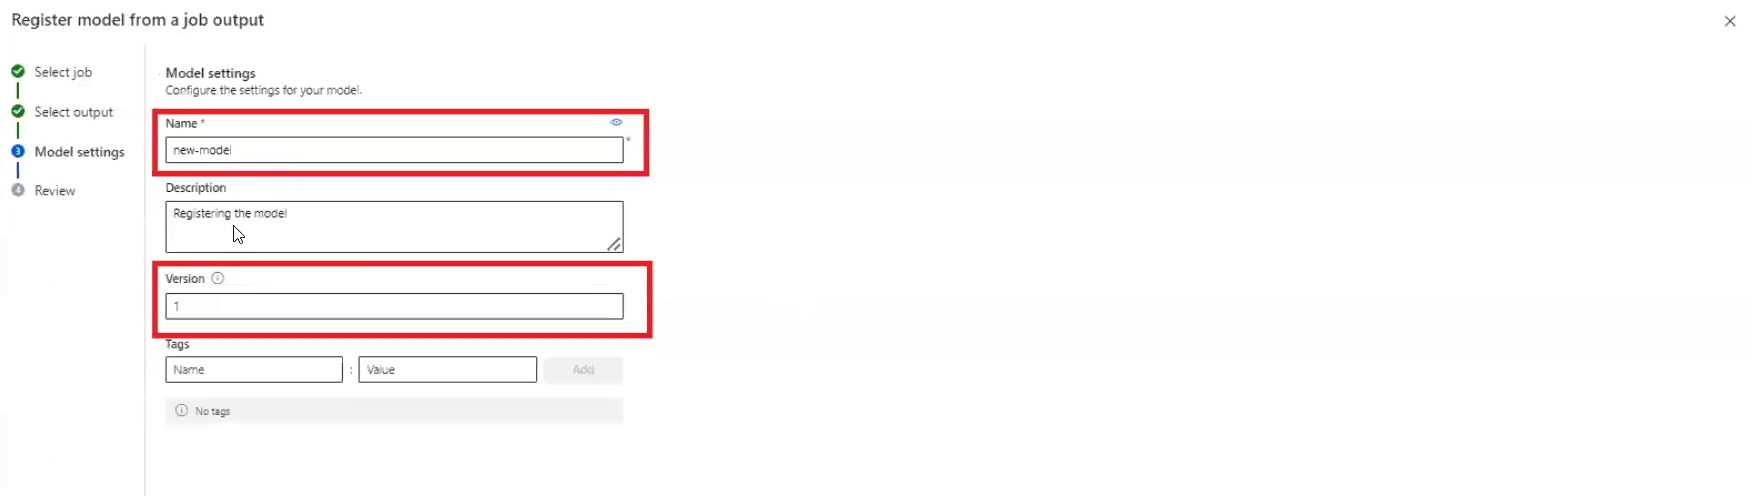

4. Register the Model

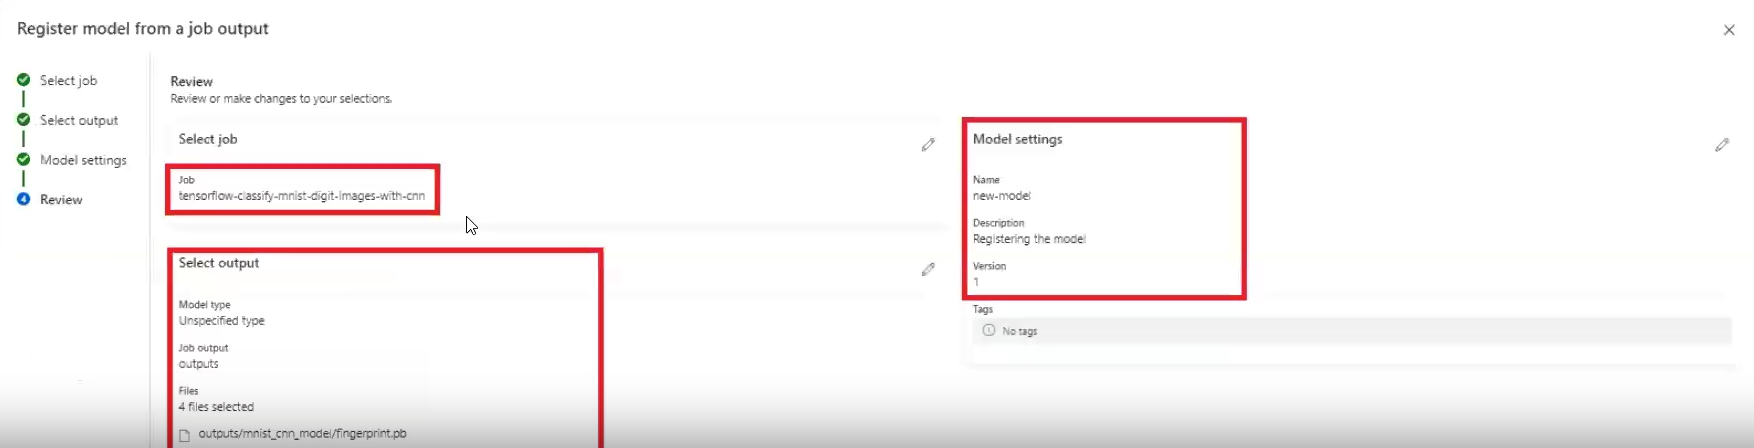

5. You will be able to see the registered model in the **Models** Section under **Assets**

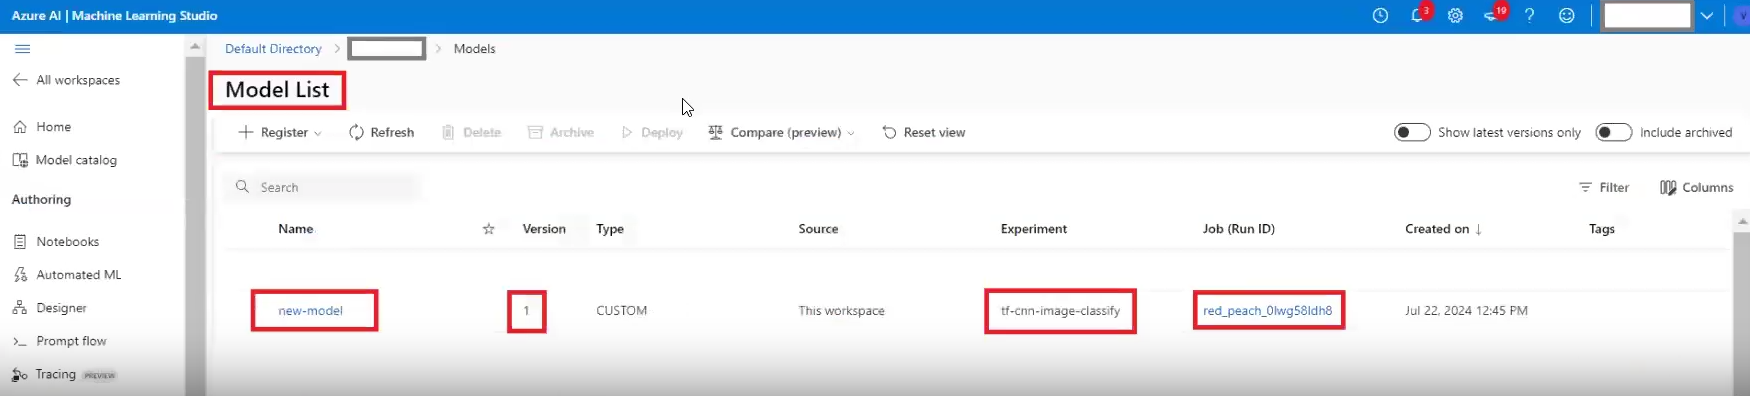

# Store the model artifacts in outputs folder
Once the model is registered, the artifacts of the models can be stored from mnist_outputs to **outputs** folder
1. Navigate to the model registered in **Models**, download all into local machine

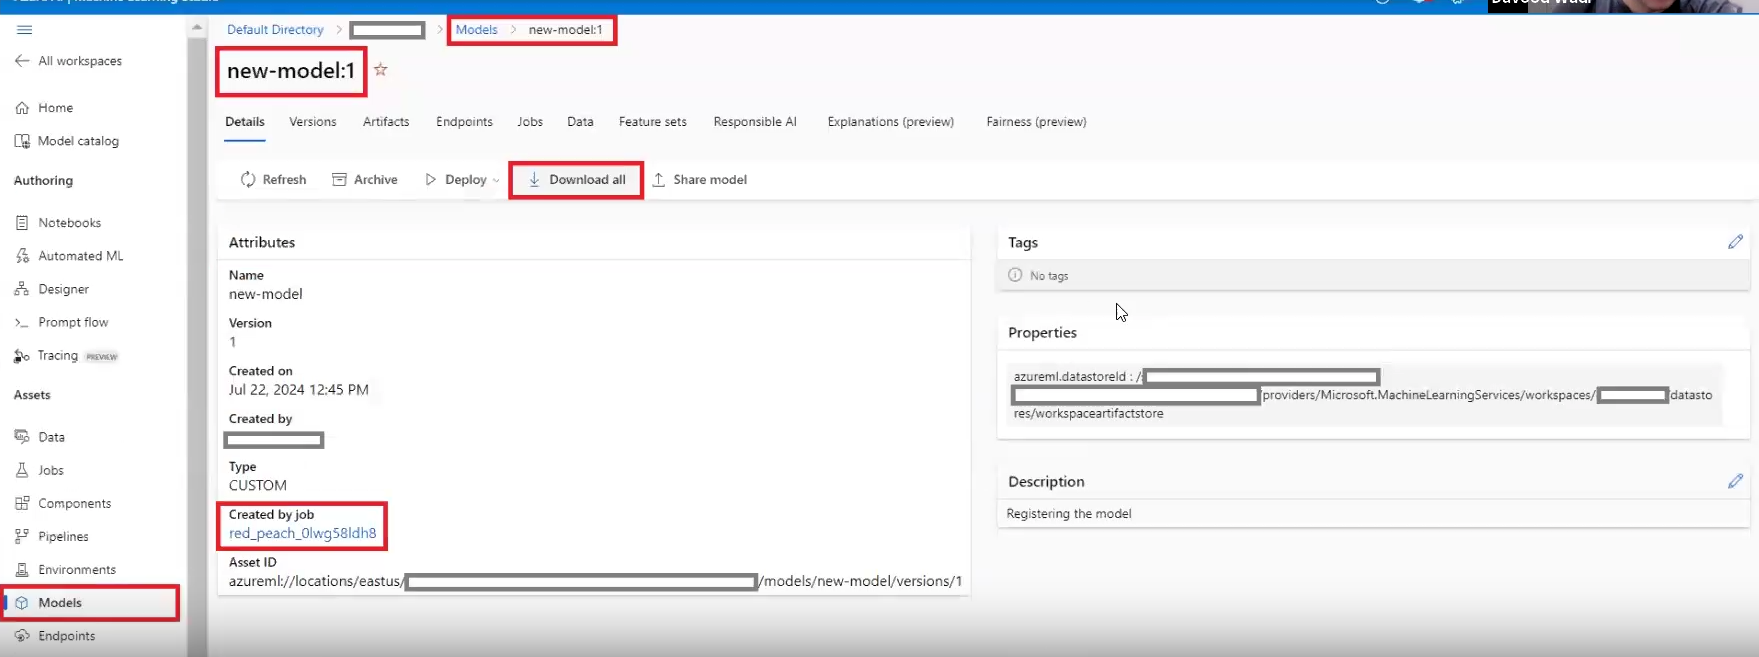

## Create Model Object for Deployment Purpose

In [ ]:
from azure.ai.ml.entities import Model

local_model_path = "mnist_outputs/new-model"

# Create the Model Object
model = Model(
    path = local_model_path,
    name = "mnist_cnn_model",
    description = "CNN Model trained on MNIST Dataset"
    type = "custom_model"
)

# Register the model in Azure Workspace
registered_model = ml_client.models.create_or_update(model)
print(f"Model Registered: {registered_model.name} (version: {registered_model.version})")


## Deploy the model as an online endpoint

After registration, the model can be deployed as an online endpoint - that is an webservice in Azure Cloud
To deploy a machine learning service, we typically need:
1. The model assets - such as model file and metadata. Create a unqiue name using a universally unique identifier (UUID)
2. Some code to run as a service. The code executes the model on a given input request ( an entry script). This entry script receives data submitted to a deployed web service and passes it to the model. After the moodel processes the data, the script returns the model's response to the client. When we use an MLFlow Model. Azure ML automatically creates this script for us.

In [24]:
import uuid

# creating a unique name for the endpoint
online_endpoint_name = "tf-cnn-endpoint-" + str(uuid.uuid4())[:8]

In [ ]:
from azure.ai.ml.entities import (
    ManagedOnlineEndpoint,
    ManagedOnlineDeployment,
    Model,
    Environment
)

# create an online endpoint
endpoint = ManagedOnlineEndpoint(
    name = online_endpoint_name,
    description= "Classify handwritten digits (CNN) usin Tensorflow",
    auth_mode = "key"
)

endpoint = ml_client.begin_create_or_update(endpoint).result()
print(f"Endpoint {endpoint.name} provisioning state: {endpoint.provisioning_state}")

3. Once we create the endpoints, we can retrieve it 

In [ ]:
endpoint = ml_client.online_endpoints.get(name = online_endpoint_name)


## Create a Scoring Script

In [28]:
%%writefile score.py
import json
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.models import load_model
from azureml.core.model import Model

def init():
    global model
    model_path = Model.get_model_path('mnist_outputs/new-model/mnist_cnn_model')
    model = tf.save_model_load(model_path)

def run(raw_data):
    data = np.array(json.loads(raw_data)["data"], dtype = np.float32)
    data = np.reshape(data, (-1, 28,28,1))
    out = model(data)
    y_hat = np.argmax(out, axis = 1)

    return y_hat.tolist()


Writing score.py


In [ ]:
registered_model = ml_client.models.get(name = "new-model", version = 1)

## Deploy the model to the endpoint
After the endpoint is created, the model can be deployed with an entry script. An endpoint can have multiple deployments. Using rules, the endpoint can direct traffic to these deployments.
In this scenario, we create a single deployment that handles 100% of the incoming traffic. 
1. Deploy the resitered model
2. Score the model using score.py (evaluate)
3. Use the same curated environment to perform inferencing

In [ ]:
model = registered_model
from azure.ai.ml.entities import CodeConfiguration

#create an online deployment
blue_deployment = ManagedOnlineDeployment(
    name = "tff-blue",
    endpoint_name=online_endpoint_name,
    model = model,
    code_configuration=CodeConfiguration(code = "", scoring_script="score.py"),
    environment=curated_env_name,
    instance_type="Standard_NC4as_T4_v3",
    instance_count = 1
)

blue_deployment = ml_client.begin_create_or_update(blue_deployment).result()

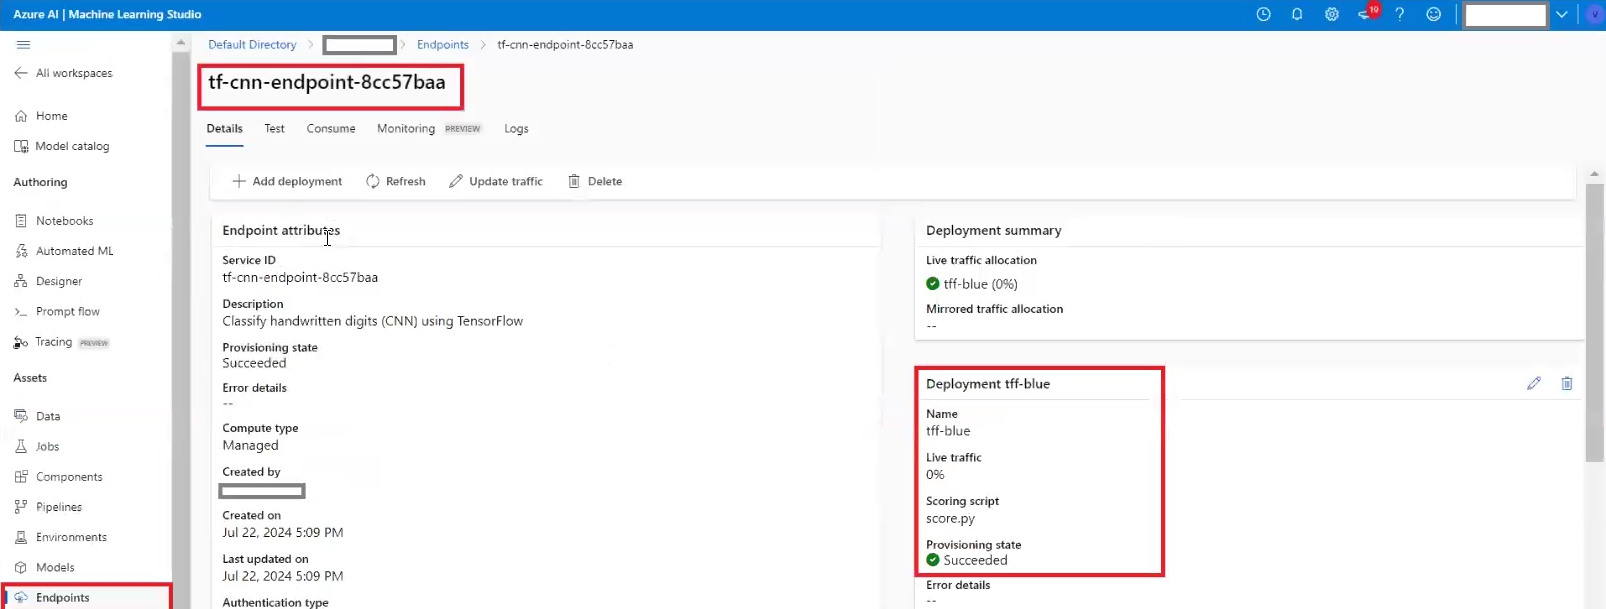

## Test the deployment with a sample query
After the model is deployed, predict the output of the deployed modek using the invoke method on the endpoint. To run the inference, we use the sample files

In [ ]:
result = ml_client.online_endpoints.invoke(
    endpoint_name=online_endpoint_name,
    request_file="sample_request_cnn.json",
    deployment_name = "tff-blue"
)

In [ ]:
result

## Cleanup resource

In [ ]:
ml_client.online_endpoints.begin_delete(name = online_endpoint_name)